✍ Последняя тема, которую нам осталось обсудить в контексте деревьев решения, — это **значимость признаков (feature importances)**.

Мы знаем, что при построении деревьев рассчитывается так называемая информативность, или важность каждого признака из обучающего набора данных. Эта величина численно отражает, насколько значимым был фактор $x_j$ для обучения модели, как много информации он даёт.

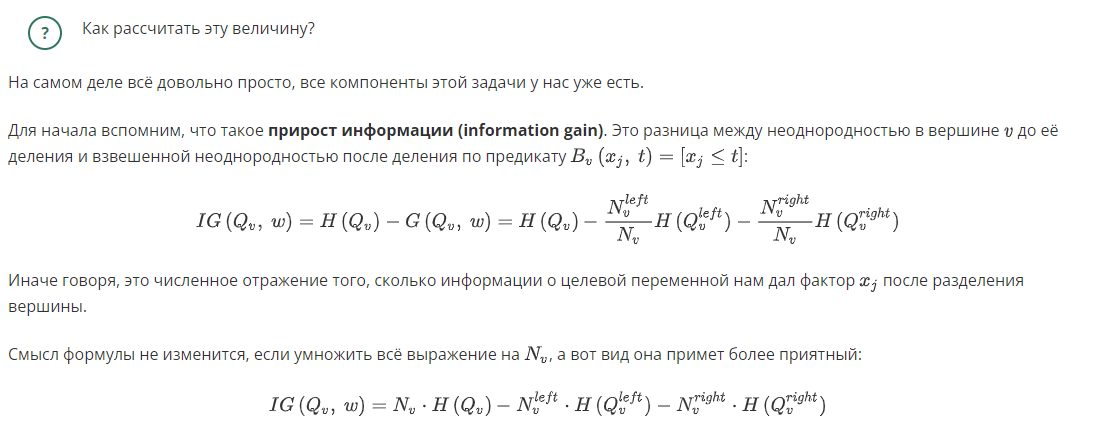

### Так как выражение для прироста информации — это не уравнение, то умножать левую часть на $N_v$ необязательно, так как мы просто переходим от одного масштаба к другому.

### Значения прироста информации $IG(Q_v, w)$, вычисленные по первой и второй формулам выше, будут различаться ровно в $N_v$ раз, однако при дальнейших вычислениях это не будет иметь значения. Нам не важно, в чём измерять прирост информации (в единицах или сотнях), так как это абстрактная величина.

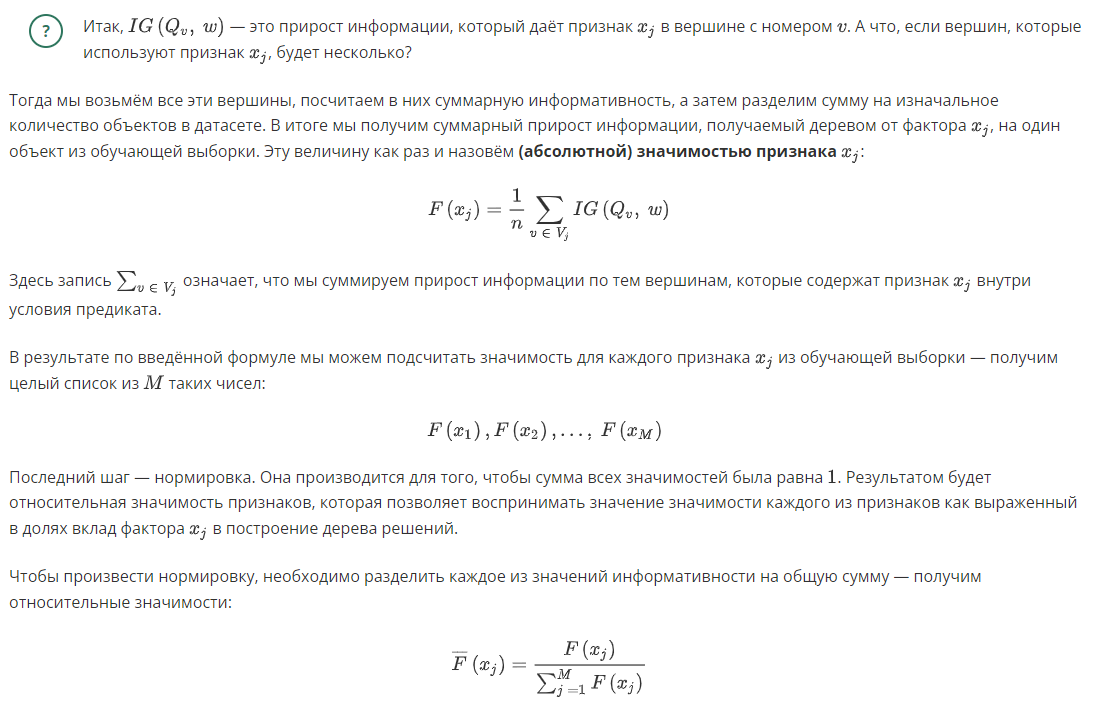
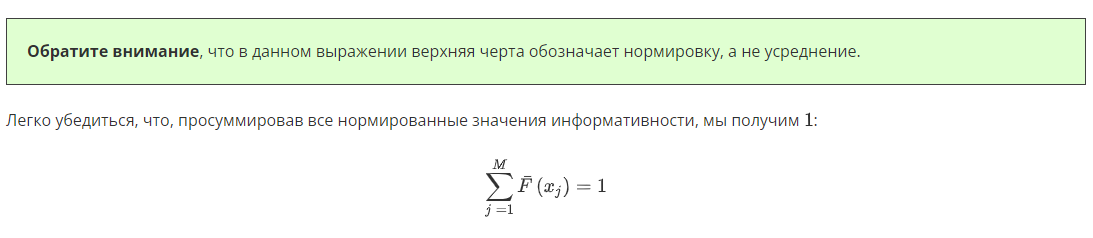




Давайте на примере посмотрим, как работают эти формулы ↓

Продолжим рассматривать датасет о выплатах кредитов банку. Напомним, что за $x_1$ мы обозначали возраст клиента (age), а за  — его доход (income). Пусть мы обучили на данных модель дерева решений и получили следующий граф:

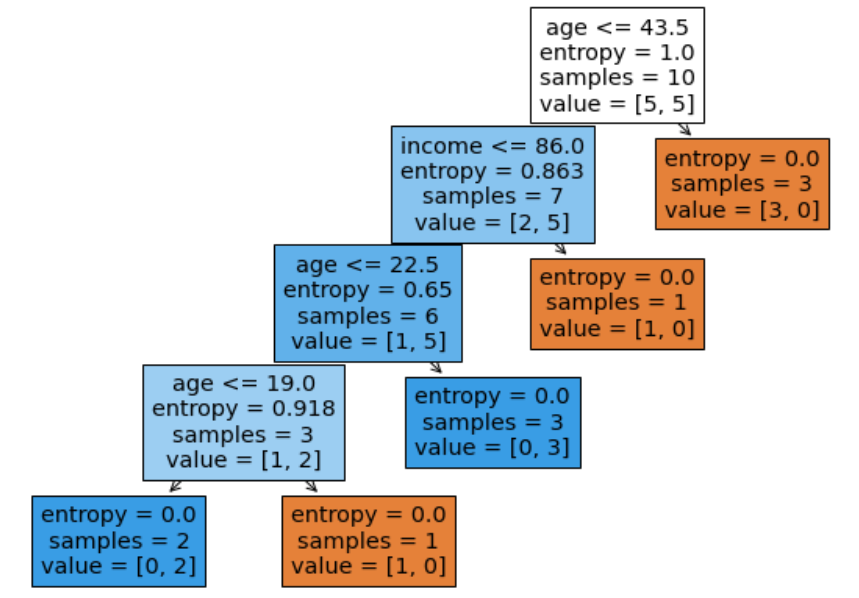

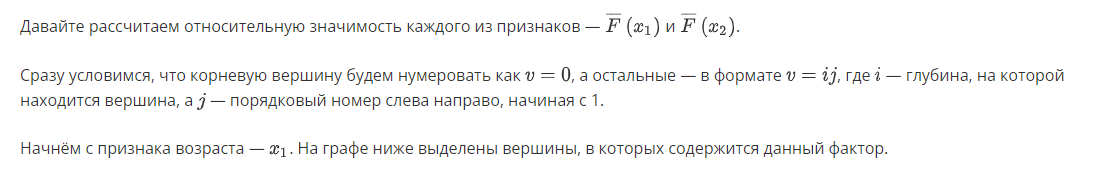

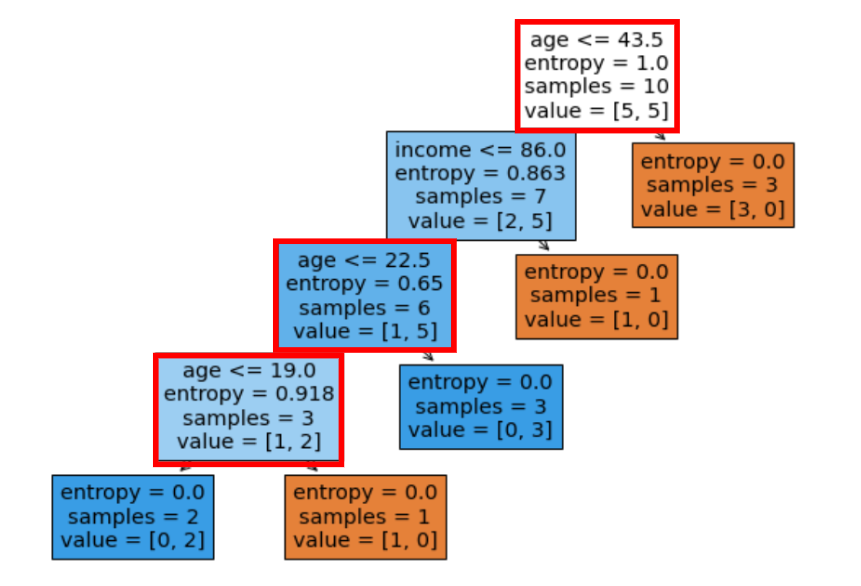
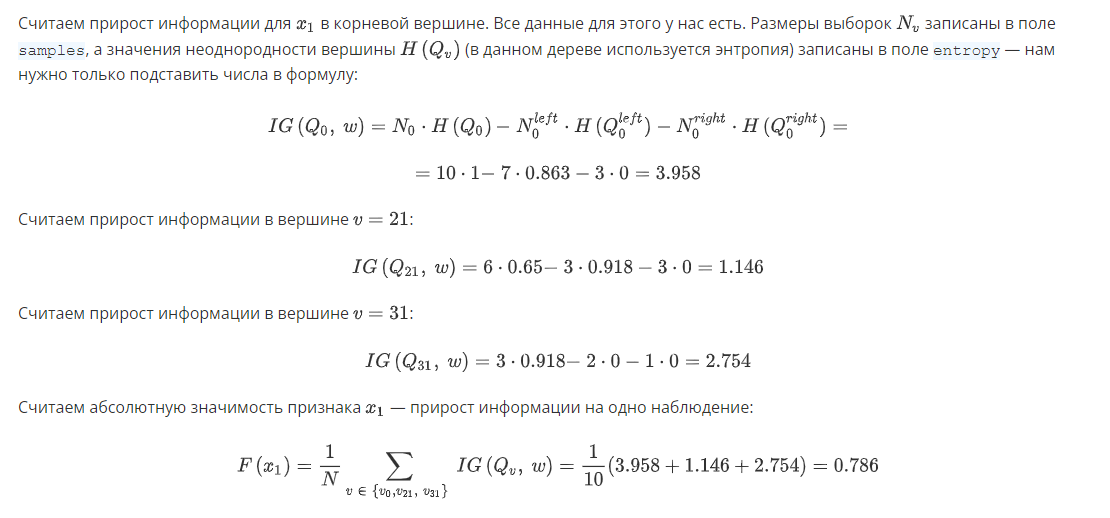

Переходим к признаку дохода — $x_2$. На графе ниже выделены вершины, в которых содержится данный фактор.

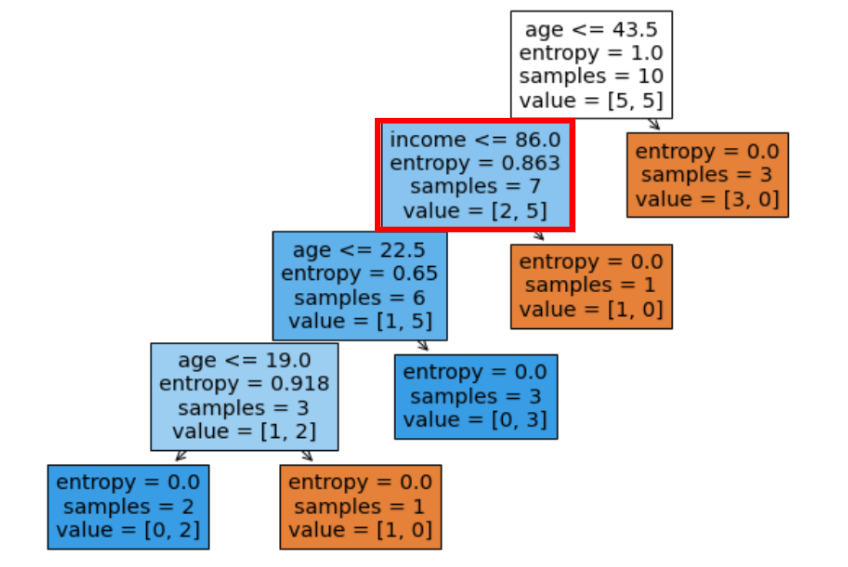
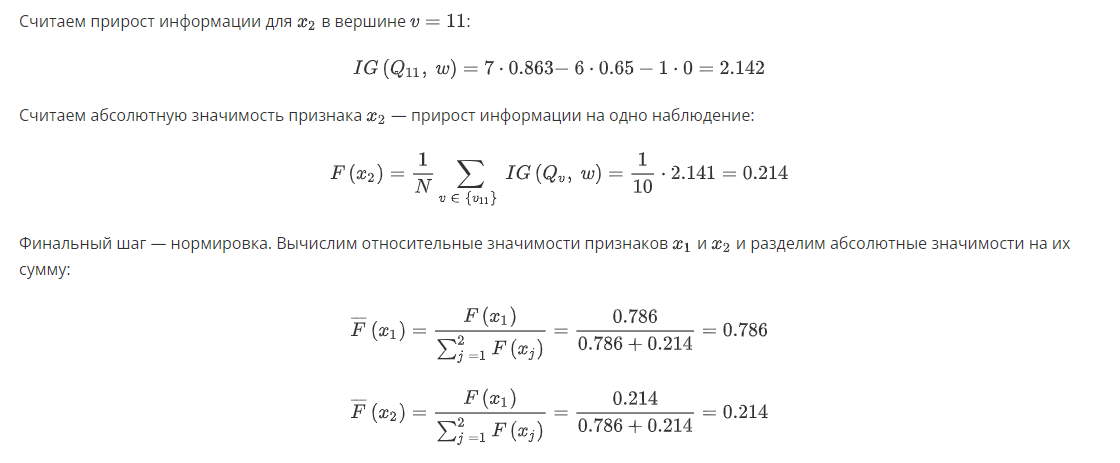


## Обратите внимание, что для случая двух факторов абсолютная и относительные значимости будут всегда совпадать.

Интерпретировать полученные результаты можно следующим образом: доля информации, которую принёс признак возраста клиента $x_1$ при построении дерева решений для целевой переменной $y$ (класса объекта — факта выплаты кредита заёмщиком), составляет $0.786$, или 78.6%. Признак заработка $x_2$ дал дереву 21.4% информации о целевой переменной.

### **Примечание.**Здесь нужно сделать важное замечание. Обратите внимание, что полученные результаты относятся к конкретному дереву решений, представленному на графе выше. Полученный результат вовсе не означает, что возраст клиента важнее его заработка при принятии решения о выдаче кредита в глобальном смысле. Принимая какую-то гипотезу и делая категоричные выводы на подобных маленьких выборках с использованием только одного дерева решений, вы рискуете допустить серьёзную исследовательскую ошибку.

### Более корректные результаты можно получить на выборках больших размеров с использованием не одного дерева решений, а целых ансамблей из деревьев (случайный лес или градиентный бустинг, о которых мы поговорим в следующем модуле).

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree


In [39]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params    

def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

def stopping_criterion(X, y, criterion):
    return criterion(y) == 0


def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)


def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

def create_leaf_prediction(y):
    value = y.mean()
    return value

def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)

def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_rigth, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node  

Реализуем функцию calculate_feature_importances() для расчёта относительных значимостей признаков. Она будет принимать на вход обученное дерево решений. Также у неё будет аргумент по умолчанию — массив из значимостей feature_importances. Так как функция будет рекурсивной, то при первом запуске массив нужно проинициализировать нулями.

Далее, до тех пор пока не «упрёмся» в листья, будем считать прирост информации для признака, записанного в вершине, и заносить результат в массив, затем рекурсивно проделывать то же самое для потомков. После окончания рекурсии образуется массив feature_importances, в котором будут лежать суммарные приросты информации по каждому из признаков. Чтобы получить относительную значимость признаков, нужно будет разделить массив на число наблюдений, а затем нормировать на сумму.

In [41]:
def calculate_feature_importances(node, feature_importance=None):
    if feature_importance is None:
        feature_importance = np.zeros(X.shape[1])
    if node.value is None:
        j = node.split_params[0]
        feature_importance[j] += node.impurity * node.samples - \
                                 node.left.impurity * node.left.samples - \
                                 node.right.impurity * node.right.samples
        calculate_feature_importances(node.left, feature_importance)
        calculate_feature_importances(node.right, feature_importance)
    feature_importance /= node.samples
    feature_importance /= feature_importance.sum()
    return feature_importance

Протестируем функцию на нашем «игрушечном» датасете о кредитах:

In [42]:
# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, entropy)
# Вычисляем значения информативности признаков
print(calculate_feature_importances(decision_tree))

[0.78582905 0.21417095]


Итак, мы получили тот же результат, что и при ручном расчёте.

Ещё один способ проверить себя — свериться с результатами библиотеки sklearn:

In [43]:
# Создаём модель дерева решений и обучаем её
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Вычисляем значения информативности признаков
print(dt.feature_importances_)

[0.78582905 0.21417095]


Результат совпал, а значит, наша функция реализована корректно.

**Примечание.** Если факторов, участвующих в построении дерева, много, то удобнее всего отсортировать их по коэффициенту значимости и визуализировать, например, в виде столбчатой диаграммы значимости. Пример:

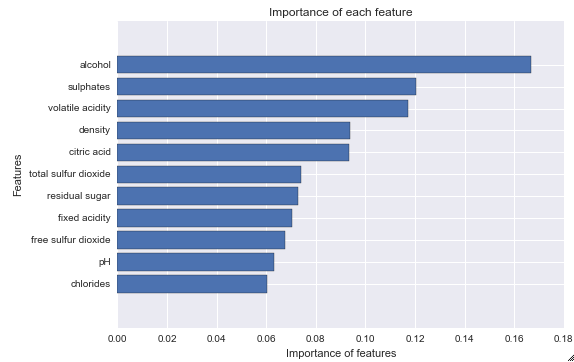

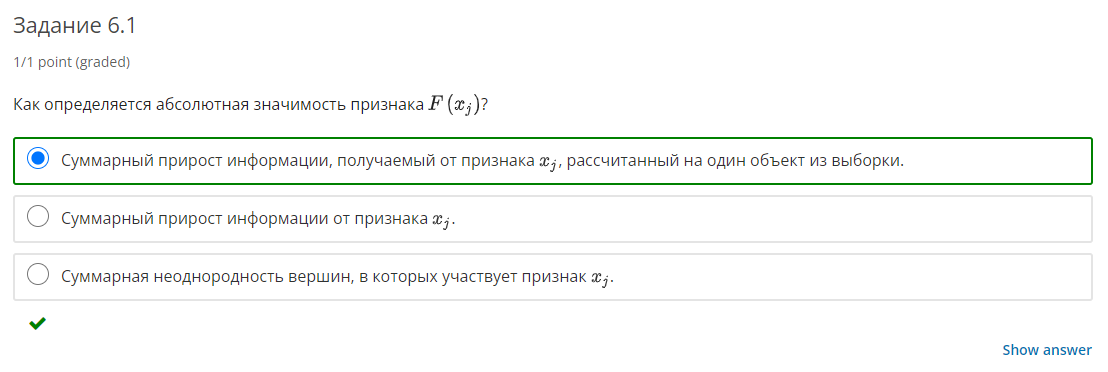

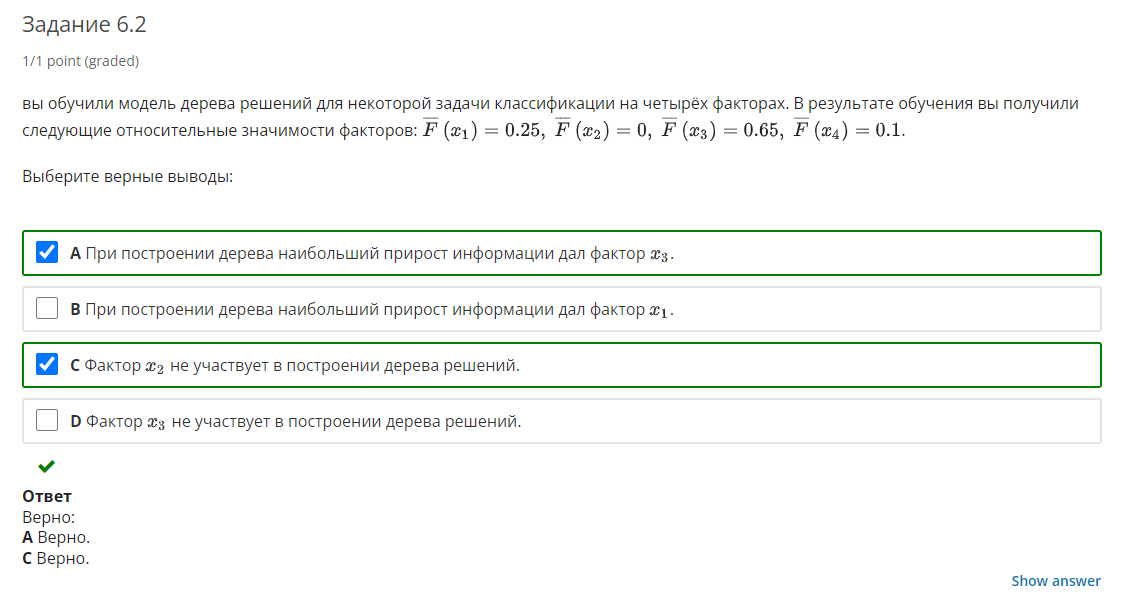

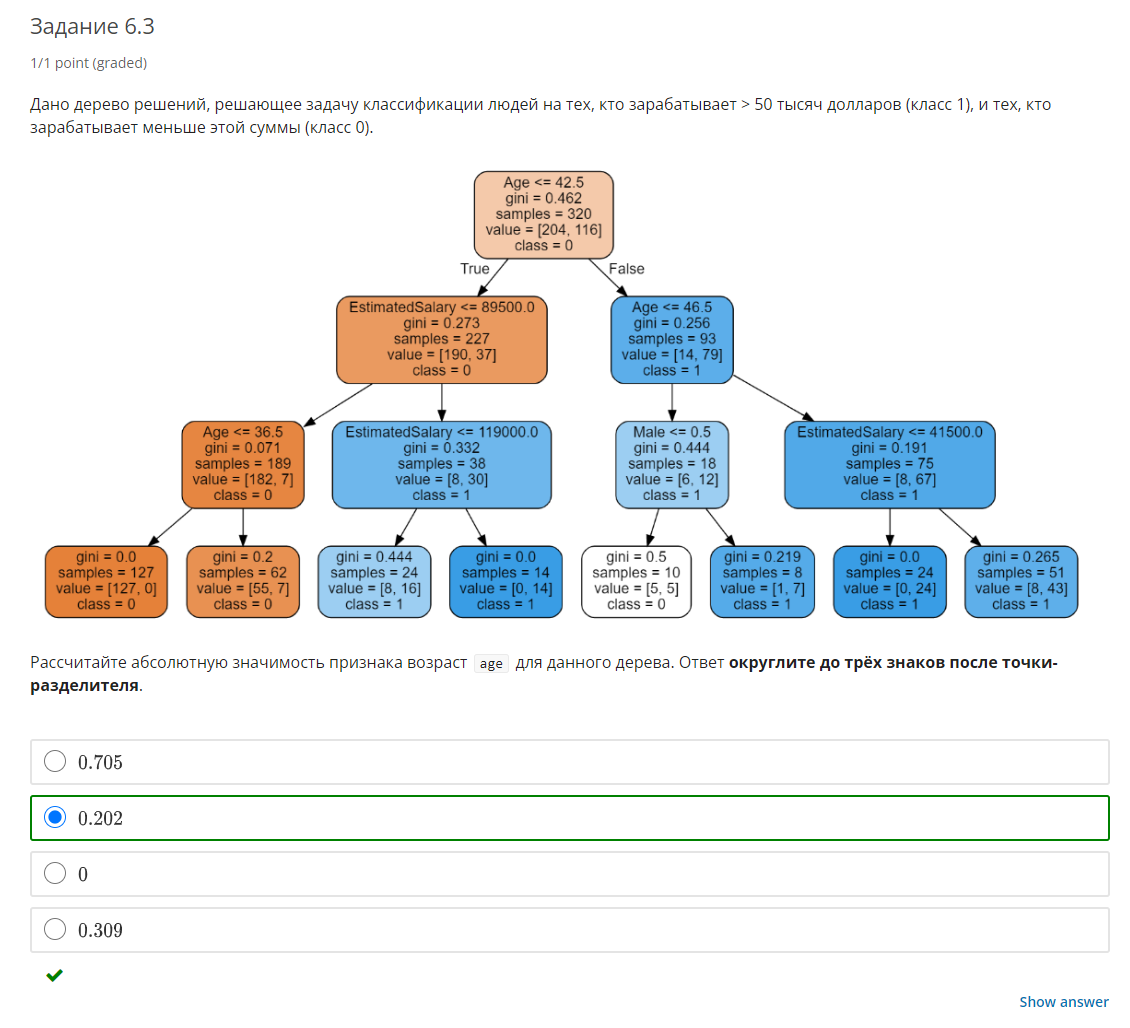
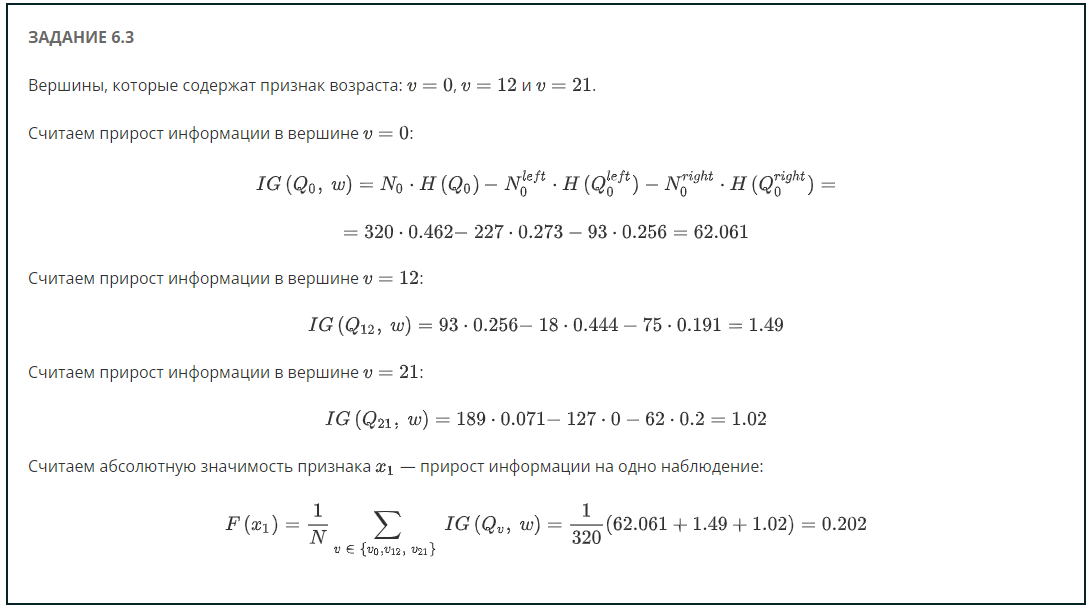